## Random Forest Algorithm

In [267]:
# Imports
from random import seed
from random import randrange
from csv import reader
from math import sqrt
import pandas as pd
import numpy as np
import json
import yaml
import matplotlib.pyplot as plt
%matplotlib inline
import pydot
import matplotlib.patches as mpatches
from IPython.display import Image
import operator
from collections import defaultdict

In [296]:
# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
        dataset.append(row)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        if row[column] == 'null':
            row[column] = None
        else:
            row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    # useful if label column coming as categories
    for i, value in enumerate(unique):
        lookup[value] = i 
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup
 
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            # gives one random number
            index = randrange(len(dataset_copy))
            # pop this random number from dataset
            fold.append(dataset_copy.pop(index))
        # add fold generated to list of folds
        dataset_split.append(fold)
    return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for i,fold in enumerate(folds):
        train_set = list(folds)
        train_set.remove(fold)
        # Converting list of lists to list
        # Ex. converts [[1],[2],[3]] to [1,2,3]
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            # Setting the label to None in test set
            row_copy[-1] = None
            test_set.append(row_copy)
        trees, predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = round(accuracy_metric(actual, predicted),4)
        scores.append(accuracy)
        if i == len(folds)-1:
            decisiontree= trees[0]
            #print(decisiontree) #print(graph)
            #print(yaml.dump(decisiontree, default_flow_style=False))
            visit(decisiontree, 0) 
            graph.write_png('decision_tree_graph.png')   
    return scores
 
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    # index here is the column index in dataset
    # value is the column/feature value based on which split has to be done 
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes): 
    # classes: number of output/label classes
    # number of split branches at a split 
    # ex. if groups = 2, meaning left and right node of the splits
    
    # count all samples at split point
    # total number of samples in left and right nodes 
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero - if there are no samples in a node
        if size == 0: 
            continue
        score = 0.0
        # score the group based on the score for each class
        node_labels = [row[-1] for row in group]
        for class_val in classes:
            # count the no. of samples of class = 1,0 etc. 
            p = node_labels.count(class_val) / size
            # calculate unweighted gini index
            score += p * (1-p)
        # weight the group score by its relative size
        # calculate gini index by weighing by the number of instances
        gini += score * (size / n_instances)
    return gini
 
# Select the best split point for a dataset
def get_split(dataset, n_features):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    features = list()
    while len(features) < n_features:
        index = randrange(len(dataset[0])-1)
        if index not in features:
            features.append(index)
    for index in features:
        # Get unique set of values for a feature (index)
        unique_values = set([row[index] for row in dataset])
        # use test split to get the distribution of nodes for each value 
        # get gini index of this test split 
        for value in unique_values:
            # groups here are the left and right node samples after splitting on the value
            groups = test_split(index, value, dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, value, gini, groups
    # returns a node with the index with which it has to be split, value and two groups after split
    features_importance[str(FIELDS[b_index])] += float(b_score)
    return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    # set the label of the terminal node to be the dominant label of the node samples based on count
    return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size, n_features):
    root = get_split(train, n_features)
    # split is called on the root node to iteratively build the tree
    split(root, max_depth, min_size, n_features, 1)
    return root # this will have the entire tree
 
# Make a prediction with a decision tree
def predict(node, row):
    # node here will be the root node
    if row[node['index']] < node['value']:
        # if the left branch is a node
        # call predict again to pass row down that node
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
        # else if it is terminal node, just return the label value
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample
 
# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return max(set(predictions), key=predictions.count)

# Building a tree traversal and graph structure for visualization 
def visit(node, depth, parent = None):
    feature=node['index']
    feature = FIELDS[feature]
    feature_value=node['value']
    left_node = node['left']
    right_node = node['right']
    child_nodes = [left_node, right_node]
    
    if depth ==0:            
        node_root = "D"+str(depth)+"_"+str(feature)
    else:
        parent = FIELDS[parent]
        node_root = "D"+str(depth)+"_"+str(parent)
    
    # processing left_child
    if isinstance(left_node, dict):
        node_child = "D"+str(depth+1)+"_"+str(FIELDS[left_node['index']])
        graph.add_edge(pydot.Edge(node_root, node_child, label="L "+str(feature_value)))
        visit(left_node,depth+1, parent=left_node['index'])
    else:
        node_terminal = "D"+str(depth+1)+"_Class_"+str(left_node)
        graph.add_edge(pydot.Edge(node_root, node_terminal, label="L "+str(feature_value)))
    
    # processing right_child
    if isinstance(right_node, dict):
        node_child = "D"+str(depth+1)+"_"+str(FIELDS[right_node['index']])
        graph.add_edge(pydot.Edge(node_root, node_child, label='R '+str(feature_value)))
        visit(right_node,depth+1, parent=right_node['index'])
    else:
        node_terminal = "D"+str(depth+1)+"_Class_"+str(right_node)
        graph.add_edge(pydot.Edge(node_root, node_terminal, label="R "+str(feature_value)))


# Random Forest Algorithm
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
    trees = list()
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        decisiontree = build_tree(sample, max_depth, min_size, n_features)
        trees.append(decisiontree)
    predictions = [bagging_predict(trees, row) for row in test]
    return(trees, predictions)


# get_accuracy
def get_accuracy(n_trees, n_folds,  max_depth, min_size):
    accuracy_list = []
    global features_importance
    print("N-folds:", n_folds, " Max_depth:", max_depth, " Min size:", min_size)
    for n_trees in number_of_trees:
        scores = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
        print('Trees: %d' % n_trees)
        print('Scores: %s' % scores)
        accuracy = round((sum(scores)/float(len(scores))),4)
        accuracy_list.append(accuracy)
        print('Mean Accuracy: %.3f%%' % accuracy)
    features_importance = sorted(features_importance.items(), key=operator.itemgetter(1))
    features_importance = [(item[0],round(item[1],2)) for item in features_importance]
    print('Features in decreasing order of importance (summed gini index for a feature across all trees - lower gini index better):\n', features_importance)

In [213]:
# Test the random forest algorithm
seed(2)

# load and prepare data
filename = 'data/toy.csv'
FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']
NUM_FIELDS = FIELDS[0:13] + ['Label']

#toy_dataset = load_csv(filename)
toy_df = pd.read_csv(filename)
numeric_df = toy_df[NUM_FIELDS].copy()
print(numeric_df.info())
print(numeric_df.iloc[0])
dataset = numeric_df.values.tolist()
print(dataset[0])

# convert string attributes to integers
#for i in range(0, len(dataset[0])-1):
#    str_column_to_float(dataset, i)

# convert class column to integers
#str_column_to_int(dataset, len(dataset[0])-1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
I1       1000 non-null object
I2       1000 non-null int64
I3       1000 non-null object
I4       1000 non-null object
I5       1000 non-null object
I6       1000 non-null object
I7       1000 non-null object
I8       1000 non-null int64
I9       1000 non-null object
I10      1000 non-null object
I11      1000 non-null object
I12      1000 non-null object
I13      1000 non-null object
Label    1000 non-null int64
dtypes: int64(3), object(11)
memory usage: 109.5+ KB
None
I1       null
I2         11
I3       null
I4       null
I5       3683
I6       null
I7          0
I8          5
I9         36
I10      null
I11         0
I12      null
I13      null
Label       0
Name: 0, dtype: object
['null', 11, 'null', 'null', '3683', 'null', '0', 5, '36', 'null', '0', 'null', 'null', 0]


In [298]:
graph = pydot.Dot(graph_type='digraph')
sample_size = 1.0
n_features = int(sqrt(len(dataset[0])-1))
number_of_trees = [1, 5, 10, 20, 30, 40, 50, 75,100,]#200]
features_importance = defaultdict(float)

get_accuracy(n_trees, n_folds = 3, max_depth = 7, min_size = 10)

N-folds: 3  Max_depth: 7  Min size: 10
Trees: 1
Scores: [66.967, 71.4715, 67.8679]
Mean Accuracy: 68.769%
Trees: 5
Scores: [73.5736, 74.7748, 70.5706]
Mean Accuracy: 72.973%
Trees: 10
Scores: [76.2763, 77.4775, 69.3694]
Mean Accuracy: 74.374%
Trees: 20
Scores: [73.8739, 74.7748, 71.4715]
Mean Accuracy: 73.373%
Trees: 30
Scores: [71.4715, 79.5796, 72.3724]
Mean Accuracy: 74.475%
Trees: 40
Scores: [74.7748, 75.3754, 72.6727]
Mean Accuracy: 74.274%
Trees: 50
Scores: [69.97, 79.2793, 76.2763]
Mean Accuracy: 75.175%
Trees: 75
Scores: [76.5766, 74.4745, 73.5736]
Mean Accuracy: 74.875%
Trees: 100
Scores: [74.1742, 72.6727, 73.8739]
Mean Accuracy: 73.574%
Features in decreasing order of importance (summed gini index for a feature across all trees - lower gini index better):
 [('I12', 274.27), ('I10', 367.16), ('I1', 599.89), ('I4', 664.48), ('I13', 731.4), ('I11', 796.58), ('I3', 802.75), ('I8', 864.13), ('I2', 905.06), ('I7', 923.9), ('I9', 990.09), ('I6', 1094.28), ('I5', 1113.38)]


N-folds: 3  Max_depth: 5  Min size: 20
Trees: 1
Scores: [72.0721, 69.0691, 68.4685]
Mean Accuracy: 69.870%
Trees: 5
Scores: [75.0751, 73.8739, 74.4745]
Mean Accuracy: 74.475%
Trees: 10
Scores: [77.4775, 69.97, 75.6757]
Mean Accuracy: 74.374%
Trees: 20
Scores: [76.2763, 71.7718, 75.6757]
Mean Accuracy: 74.575%
Trees: 30
Scores: [76.2763, 73.2733, 72.973]
Mean Accuracy: 74.174%
Trees: 40
Scores: [75.6757, 74.4745, 76.2763]
Mean Accuracy: 75.475%
Trees: 50
Scores: [73.8739, 76.2763, 74.1742]
Mean Accuracy: 74.775%
N-folds: 3  Max_depth: 7  Min size: 20
Trees: 1
Scores: [65.1652, 64.5646, 69.3694]
Mean Accuracy: 66.366%
Trees: 5
Scores: [72.0721, 76.2763, 74.1742]
Mean Accuracy: 74.174%
Trees: 10
Scores: [72.3724, 76.5766, 72.973]
Mean Accuracy: 73.974%
Trees: 20
Scores: [75.3754, 72.3724, 74.4745]
Mean Accuracy: 74.074%
Trees: 30
Scores: [73.8739, 72.0721, 75.0751]
Mean Accuracy: 73.674%
Trees: 40
Scores: [73.5736, 73.8739, 75.976]
Mean Accuracy: 74.475%
Trees: 50
Scores: [78.0781, 72.072

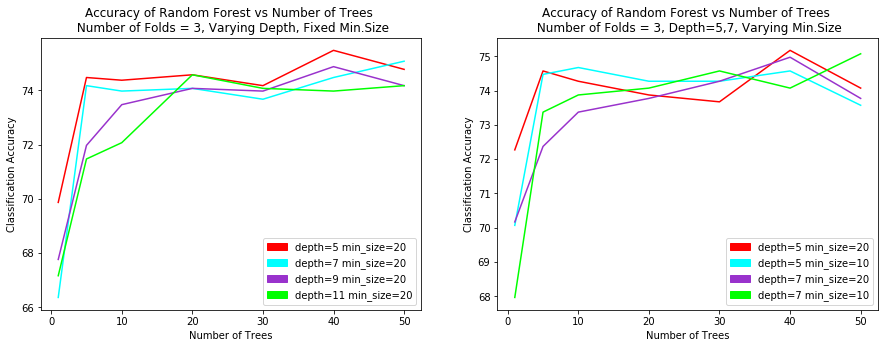

In [259]:
#Plotting graphs 
plt.figure(figsize=(15,5),) 
plt.subplot(1,2,1)
plt.title("Accuracy of Random Forest vs Number of Trees \n Number of Folds = 3, Varying Depth, Fixed Min.Size")
plt.xlabel('Number of Trees')
plt.ylabel('Classification Accuracy')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 5, min_size = 20), color='red')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 7, min_size = 20), color='aqua')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 9, min_size = 20), color='darkorchid')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 11, min_size = 20), color = 'lime')
red_patch = mpatches.Patch(color='red', label='depth=5 min_size=20')
aqua_patch = mpatches.Patch(color='aqua', label='depth=7 min_size=20')
darkorchid_patch =  mpatches.Patch(color='darkorchid', label='depth=9 min_size=20')
lime_patch =  mpatches.Patch(color='lime', label='depth=11 min_size=20')
plt.legend(handles=[red_patch, aqua_patch, darkorchid_patch, lime_patch])
plt.subplot(1,2,2)
plt.title("Accuracy of Random Forest vs Number of Trees \n Number of Folds = 3, Depth=5,7, Varying Min.Size")
plt.xlabel('Number of Trees')
plt.ylabel('Classification Accuracy')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 5, min_size = 20), color='red')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 5, min_size = 10), color='aqua')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 7, min_size = 20), color='darkorchid')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 7, min_size = 10), color = 'lime')
red_patch = mpatches.Patch(color='red', label='depth=5 min_size=20')
aqua_patch = mpatches.Patch(color='aqua', label='depth=5 min_size=10')
darkorchid_patch =  mpatches.Patch(color='darkorchid', label='depth=7 min_size=20')
lime_patch =  mpatches.Patch(color='lime', label='depth=7 min_size=10')
plt.legend(handles=[red_patch, aqua_patch, darkorchid_patch, lime_patch])

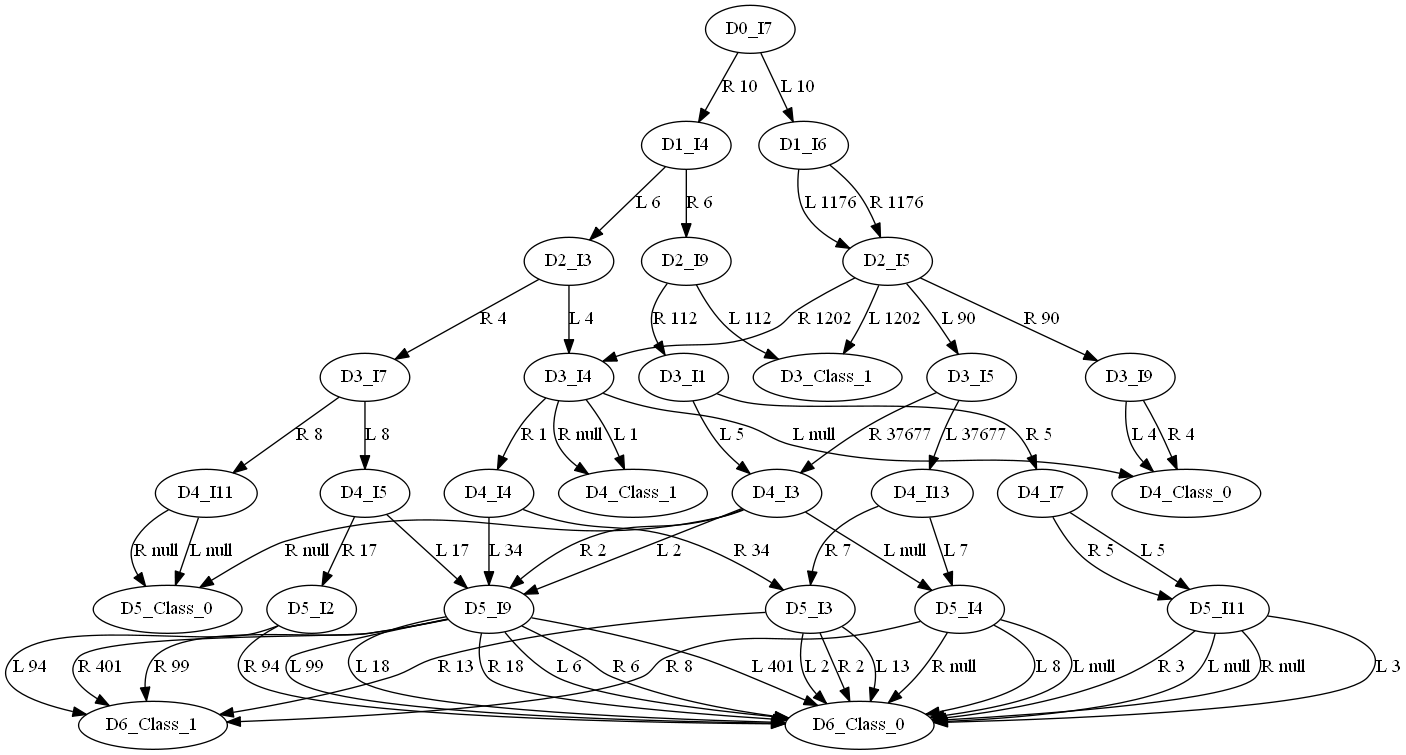

In [262]:
Image(filename="sample_output_decisiontree.png")